# NLP Sentiment Analysis with API Deployment

## Project Overview
This project implements a complete NLP sentiment analysis pipeline using the IMDB movie reviews dataset:

1. **Data Acquisition**: Load and explore the IMDB dataset
2. **Preprocessing**: Clean text, tokenization, stop-word removal
3. **Feature Engineering**: TF-IDF vectorization
4. **Modeling**: Train multiple classifiers (Naive Bayes, Logistic Regression, SVM)
5. **Evaluation**: Cross-validation, metrics, ROC curves
6. **API Deployment**: Flask/FastAPI wrapper for model serving
7. **Containerization**: Docker setup for production deployment

## Key Technologies
- **Python**: Core programming language
- **scikit-learn**: Machine learning pipelines and algorithms
- **NLTK/spaCy**: Natural language processing
- **Flask/FastAPI**: REST API framework
- **Docker**: Containerization
- **TensorFlow/Keras**: Dataset loading

In [1]:
# Import Required Libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import sklearn
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Libraries imported successfully!
Python version: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
NumPy version: 2.3.1
Pandas version: 2.3.0
Scikit-learn version: 1.7.0


## 1. Data Acquisition

We'll load the IMDB dataset using TensorFlow/Keras. The dataset contains 50,000 movie reviews with binary sentiment labels (positive/negative).

In [2]:
# Load IMDB dataset from Kaggle
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

# Load the dataset
csv_file = os.path.join(path, "IMDB Dataset.csv")
df = pd.read_csv(csv_file)

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Check sentiment distribution
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Basic statistics
print(f"\nDataset statistics:")
print(f"Total reviews: {len(df)}")
print(f"Positive reviews: {len(df[df['sentiment'] == 'positive'])}")
print(f"Negative reviews: {len(df[df['sentiment'] == 'negative'])}")
print(f"Average review length: {df['review'].str.len().mean():.1f} characters")
print(f"Shortest review: {df['review'].str.len().min()} characters")
print(f"Longest review: {df['review'].str.len().max()} characters")

Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\lakshmi25npathi\imdb-dataset-of-50k-movie-reviews\versions\1
Dataset loaded successfully!
Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Missing values:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Dataset statistics:
Total reviews: 50000
Positive reviews: 25000
Negative reviews: 25000
Average review length: 1309.4 characters
Shortest review: 32 characters
Longest review: 13704 characters


## 2. Data Exploration and Visualization

Let's explore the dataset characteristics and visualize key patterns.

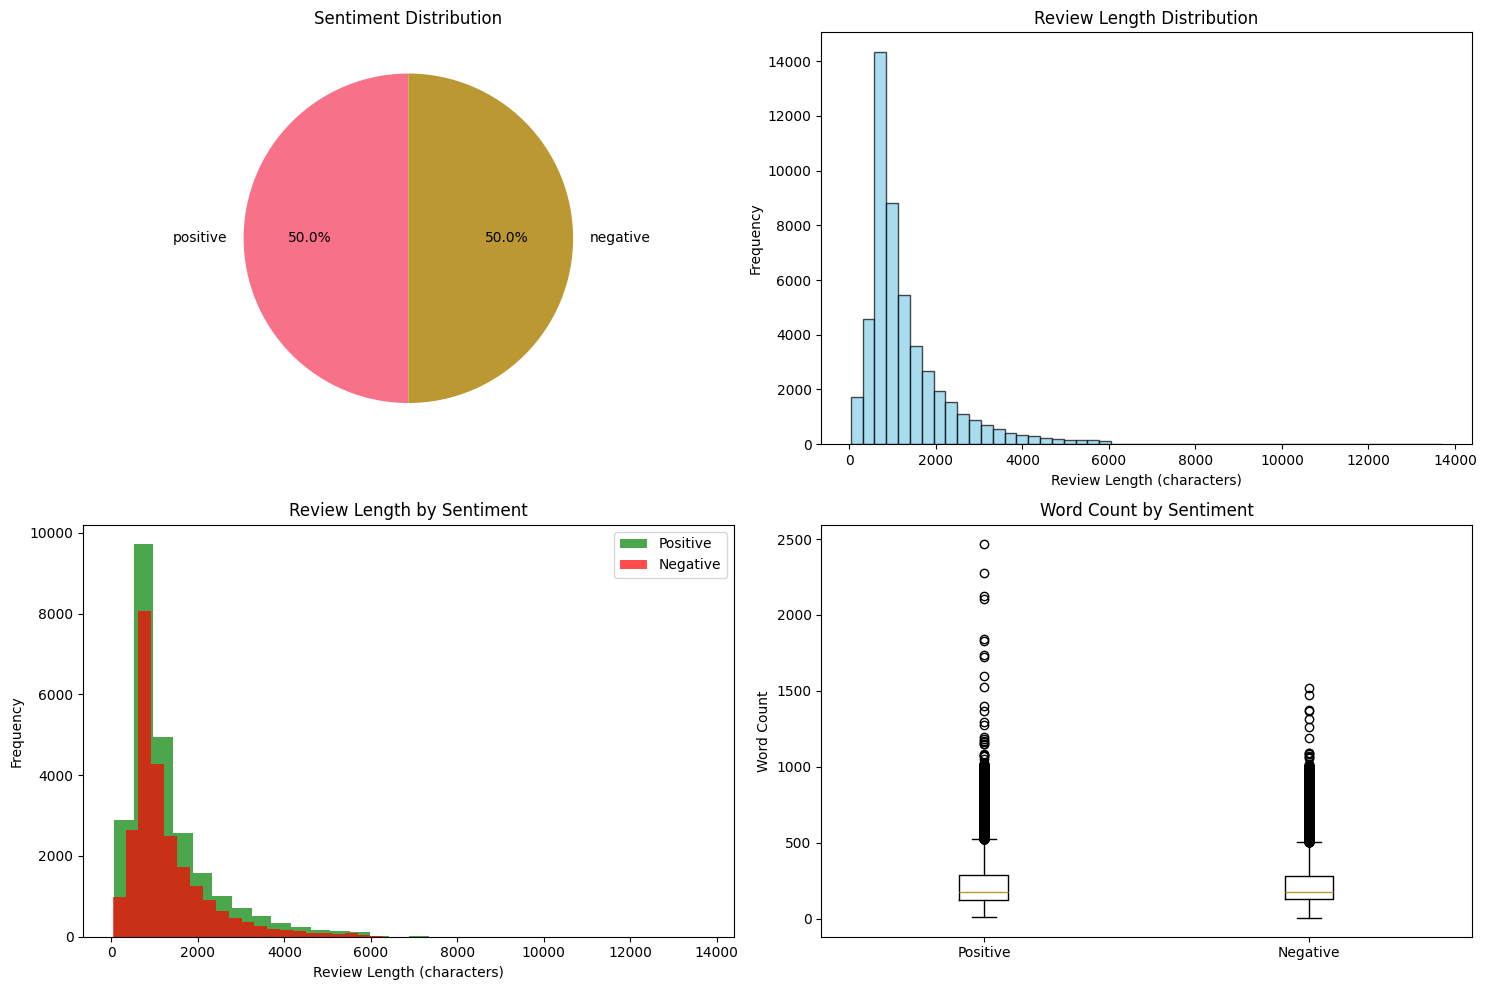


Summary Statistics:
Average words per review: 231.2
Median words per review: 173.0
Standard deviation: 171.3

By Sentiment:
Positive reviews:
  - Average length: 1324.8 characters
  - Average words: 232.8
  - Median words: 172.0
Negative reviews:
  - Average length: 1294.1 characters
  - Average words: 229.5
  - Median words: 174.0

SAMPLE REVIEWS

Positive Review Sample:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru...

Negative Review Sample:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going 

In [4]:
# Data Exploration and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Sentiment Distribution
sentiment_counts = df['sentiment'].value_counts()
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Sentiment Distribution')

# 2. Review Length Distribution
review_lengths = df['review'].str.len()
axes[0, 1].hist(review_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Review Length Distribution')
axes[0, 1].set_xlabel('Review Length (characters)')
axes[0, 1].set_ylabel('Frequency')

# 3. Review Length by Sentiment
positive_lengths = df[df['sentiment'] == 'positive']['review'].str.len()
negative_lengths = df[df['sentiment'] == 'negative']['review'].str.len()

axes[1, 0].hist(positive_lengths, bins=30, alpha=0.7, label='Positive', color='green')
axes[1, 0].hist(negative_lengths, bins=30, alpha=0.7, label='Negative', color='red')
axes[1, 0].set_title('Review Length by Sentiment')
axes[1, 0].set_xlabel('Review Length (characters)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Word Count Distribution
df['word_count'] = df['review'].str.split().str.len()
axes[1, 1].boxplot([df[df['sentiment'] == 'positive']['word_count'], 
                   df[df['sentiment'] == 'negative']['word_count']], 
                   labels=['Positive', 'Negative'])
axes[1, 1].set_title('Word Count by Sentiment')
axes[1, 1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average words per review: {df['word_count'].mean():.1f}")
print(f"Median words per review: {df['word_count'].median():.1f}")
print(f"Standard deviation: {df['word_count'].std():.1f}")

print("\nBy Sentiment:")
for sentiment in ['positive', 'negative']:
    subset = df[df['sentiment'] == sentiment]
    print(f"{sentiment.capitalize()} reviews:")
    print(f"  - Average length: {subset['review'].str.len().mean():.1f} characters")
    print(f"  - Average words: {subset['word_count'].mean():.1f}")
    print(f"  - Median words: {subset['word_count'].median():.1f}")

# Sample reviews
print("\n" + "="*50)
print("SAMPLE REVIEWS")
print("="*50)
print("\nPositive Review Sample:")
print(df[df['sentiment'] == 'positive']['review'].iloc[0][:300] + "...")
print("\nNegative Review Sample:")
print(df[df['sentiment'] == 'negative']['review'].iloc[0][:300] + "...")

## 3. Text Preprocessing

We'll clean and preprocess the text data by:
1. Removing HTML tags
2. Converting to lowercase
3. Removing punctuation and special characters
4. Tokenization
5. Removing stop words
6. Stemming/Lemmatization

In [3]:
# Text Preprocessing Functions
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Install BeautifulSoup if not available
try:
    from bs4 import BeautifulSoup
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "beautifulsoup4"])
    from bs4 import BeautifulSoup

# Initialize stemmer and stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove punctuation and special characters, keep only alphanumeric and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def preprocess_text(text, remove_stopwords=True, apply_stemming=True):
    """
    Advanced text preprocessing with tokenization, stop word removal, and stemming
    """
    # Clean the text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words if requested
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Apply stemming if requested
    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]
    
    # Join tokens back into text
    return ' '.join(tokens)

# Test the preprocessing functions
print("Testing text preprocessing:")
sample_text = df['review'].iloc[0]
print(f"Original text (first 200 chars): {sample_text[:200]}...")
print(f"Cleaned text: {clean_text(sample_text)[:200]}...")
print(f"Fully processed text: {preprocess_text(sample_text)[:200]}...")

# Process a small sample to test
print("\nProcessing sample reviews...")
sample_df = df.head(5).copy()
sample_df['cleaned_review'] = sample_df['review'].apply(clean_text)
sample_df['processed_review'] = sample_df['review'].apply(preprocess_text)

print("Sample processing results:")
for i, row in sample_df.iterrows():
    print(f"\nReview {i+1} ({row['sentiment']}):")
    print(f"Original: {row['review'][:100]}...")
    print(f"Processed: {row['processed_review'][:100]}...")

Testing text preprocessing:
Original text (first 200 chars): One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Cleaned text: one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brut...
Fully processed text: one review mention watch oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug s...

Processing sample reviews...
Sample processing results:

Review 1 (positive):
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Processed: one review mention watch oz episod youll hook right exactli happen meth first thing str

## 4. Feature Engineering

We'll convert the preprocessed text into numerical features using TF-IDF vectorization.

In [4]:
# Feature Engineering - TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Process the entire dataset
print("Processing the entire dataset...")
print("This may take a few minutes...")

# Apply text preprocessing to all reviews
df['processed_review'] = df['review'].apply(lambda x: preprocess_text(x, remove_stopwords=True, apply_stemming=True))

# Convert sentiment labels to binary (0 for negative, 1 for positive)
df['sentiment_binary'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# Split the dataset into training and testing sets
X = df['processed_review']
y = df['sentiment_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training positive samples: {sum(y_train)}")
print(f"Training negative samples: {len(y_train) - sum(y_train)}")
print(f"Test positive samples: {sum(y_test)}")
print(f"Test negative samples: {len(y_test) - sum(y_test)}")

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    min_df=2,          # Ignore terms that appear in fewer than 2 documents
    max_df=0.8,        # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2), # Use unigrams and bigrams
    stop_words='english'
)

# Fit and transform the training data
print("\nVectorizing text data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Number of features: {X_train_tfidf.shape[1]}")
print(f"Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

# Show some feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample feature names: {feature_names[:20]}")
print(f"Sample feature names (last 20): {feature_names[-20:]}")

print("\nFeature engineering completed successfully!")

Processing the entire dataset...
This may take a few minutes...
Training set size: 40000
Test set size: 10000
Training positive samples: 20000
Training negative samples: 20000
Test positive samples: 5000
Test negative samples: 5000

Vectorizing text data...
TF-IDF feature matrix shape: (40000, 5000)
Number of features: 5000
Sparsity: 98.50%

Sample feature names: ['abandon' 'abc' 'abil' 'abl' 'abomin' 'abort' 'absenc' 'absent' 'absolut'
 'absolut love' 'absolut noth' 'absorb' 'absurd' 'abus' 'abysm' 'academi'
 'academi award' 'accent' 'accept' 'access']
Sample feature names (last 20): ['yesterday' 'york' 'york citi' 'youd' 'youll' 'young' 'young boy'
 'young girl' 'young man' 'young peopl' 'young woman' 'younger' 'youth'
 'youv' 'youv got' 'youv seen' 'zero' 'zombi' 'zombi movi' 'zone']

Feature engineering completed successfully!


## 5. Machine Learning Modeling

We'll train and compare multiple classifiers:
1. Multinomial Naive Bayes
2. Logistic Regression
3. Linear Support Vector Machine
4. Compare performance using cross-validation

In [5]:
# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import time

# Initialize models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
print("Training and evaluating models...")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = None
    
    # Get prediction probabilities if available
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_proba = model.decision_function(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc = None
    
    training_time = time.time() - start_time
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'training_time': training_time
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if auc:
        print(f"AUC: {auc:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print("-" * 30)

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1-Score': [results[name]['f1'] for name in results.keys()],
    'AUC': [results[name]['auc'] if results[name]['auc'] else 0 for name in results.keys()],
    'Training Time (s)': [results[name]['training_time'] for name in results.keys()]
})

print("\nModel Comparison:")
print(results_df.round(4))

Training and evaluating models...

Training Multinomial Naive Bayes...
Accuracy: 0.8505
Precision: 0.8373
Recall: 0.8700
F1-Score: 0.8534
AUC: 0.9261
Training Time: 0.07 seconds
------------------------------

Training Logistic Regression...
Accuracy: 0.8845
Precision: 0.8766
Recall: 0.8950
F1-Score: 0.8857
AUC: 0.9532
Training Time: 0.29 seconds
------------------------------

Training Linear SVM...
Accuracy: 0.8775
Precision: 0.8708
Recall: 0.8866
F1-Score: 0.8786
AUC: 0.9486
Training Time: 1.85 seconds
------------------------------

Training Random Forest...
Accuracy: 0.8451
Precision: 0.8537
Recall: 0.8330
F1-Score: 0.8432
AUC: 0.9248
Training Time: 138.41 seconds
------------------------------

Model Comparison:
                     Model  Accuracy  Precision  Recall  F1-Score     AUC  \
0  Multinomial Naive Bayes    0.8505     0.8373  0.8700    0.8534  0.9261   
1      Logistic Regression    0.8845     0.8766  0.8950    0.8857  0.9532   
2               Linear SVM    0.8775     

## 6. Model Evaluation and Visualization

Let's visualize the model performance and create detailed evaluation reports.

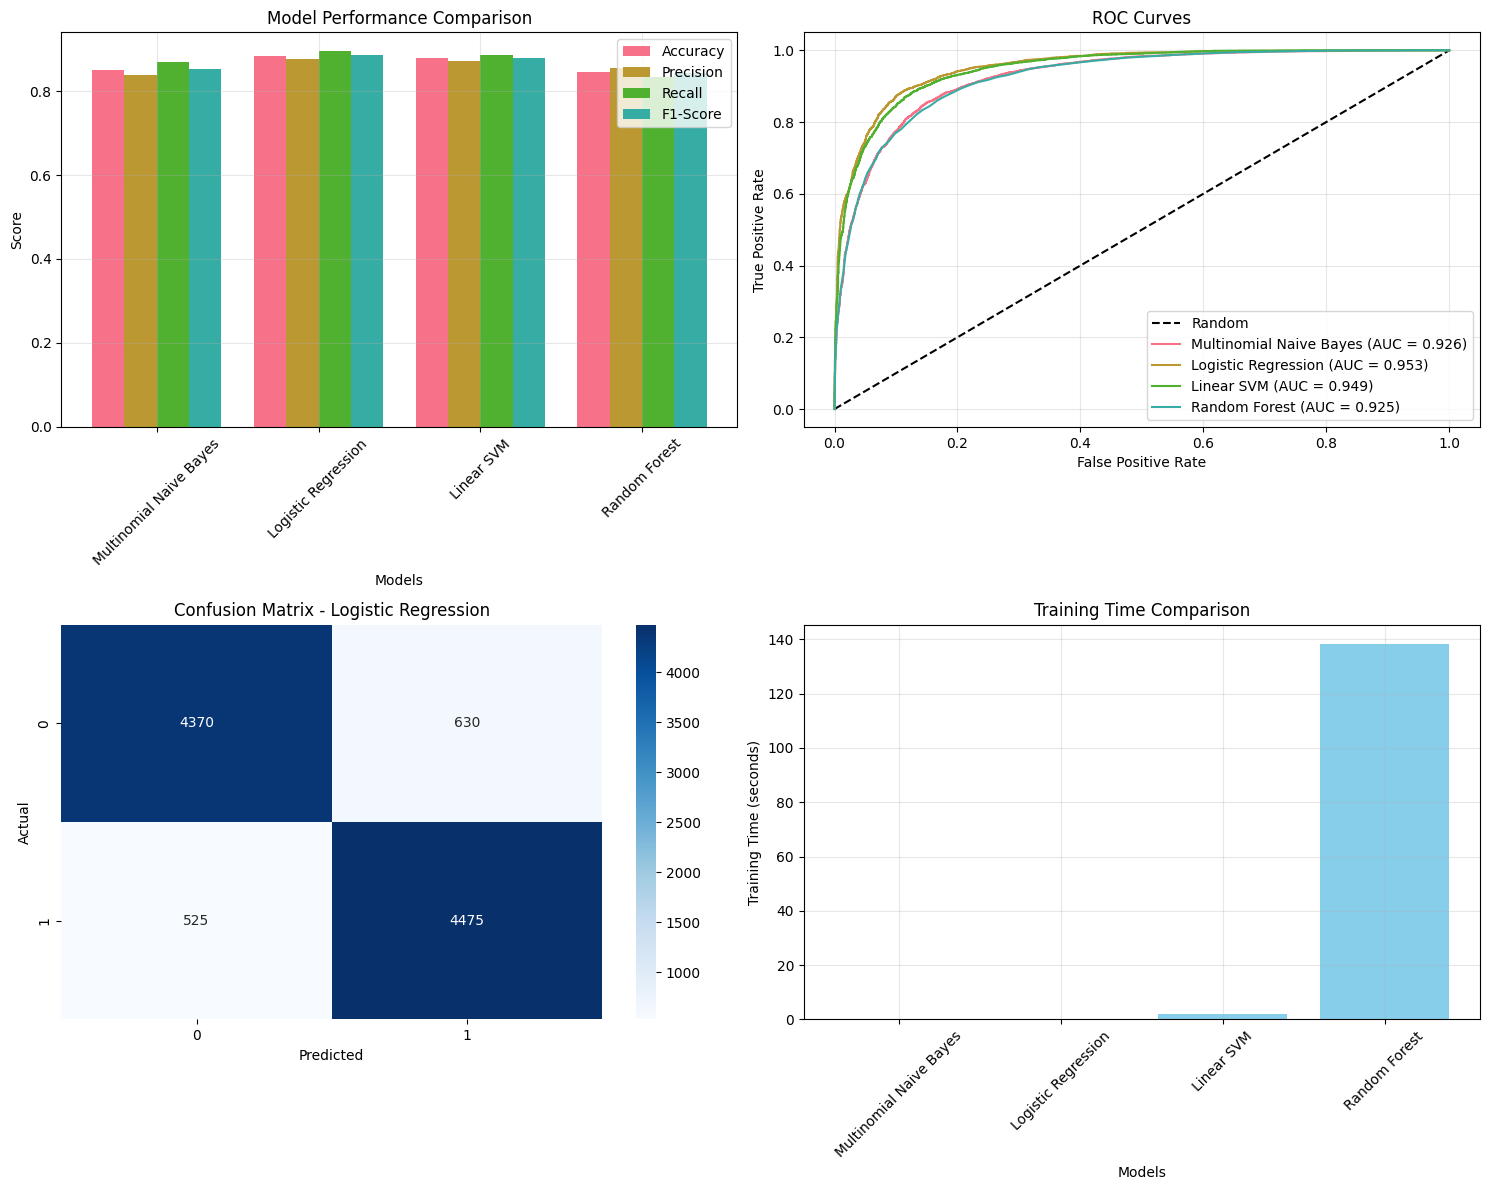


Detailed Classification Report for Best Model (Logistic Regression):
              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Cross-Validation Results for Logistic Regression:
----------------------------------------
Cross-Validation F1-Scores: [0.88790778 0.87766221 0.88676908 0.88132678 0.87940814]
Mean F1-Score: 0.8826 (+/- 0.0081)

Top 10 Positive Features (indicating positive sentiment):
excel: 7.4887
great: 6.0879
perfect: 5.9127
hilari: 4.9321
amaz: 4.9016
enjoy: 4.8673
best: 4.7727
favorit: 4.7157
brilliant: 4.5063
superb: 4.2273

Top 10 Negative Features (indicating negative sentiment):
worst: -9.8004
wast: -8.7204
aw: -8.4267
bore: -6.7447
bad: -6.5935
poor: -6.2622
disappoint: -6.1476
wors: -5.7222
terribl: 

In [7]:
# Model Evaluation and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Performance Comparison
models_list = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(models_list))
width = 0.2

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in models_list]
    axes[0, 0].bar(x + i * width, values, width, label=metric_labels[i])

axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_xticks(x + width * 1.5)
axes[0, 0].set_xticklabels(models_list, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ROC Curves
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
for name, result in results.items():
    if result['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        auc = result['auc']
        axes[0, 1].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curves')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix for Best Model (highest F1-score)
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_predictions = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 4. Training Time Comparison
training_times = [results[model]['training_time'] for model in models_list]
axes[1, 1].bar(models_list, training_times, color='skyblue')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed classification report for best model
print(f"\nDetailed Classification Report for Best Model ({best_model_name}):")
print("=" * 60)
print(classification_report(y_test, best_predictions, target_names=['Negative', 'Positive']))

# Cross-validation for best model
print(f"\nCross-Validation Results for {best_model_name}:")
print("-" * 40)
best_model = results[best_model_name]['model']
cv_scores = cross_val_score(best_model, X_train_tfidf, y_train, cv=5, scoring='f1')
print(f"Cross-Validation F1-Scores: {cv_scores}")
print(f"Mean F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    top_indices = np.argsort(feature_importance)[-20:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_importance)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Features - {best_model_name}')
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    # For linear models, show coefficients
    coef = best_model.coef_[0]
    top_positive_indices = np.argsort(coef)[-10:]
    top_negative_indices = np.argsort(coef)[:10]
    
    print(f"\nTop 10 Positive Features (indicating positive sentiment):")
    for i in top_positive_indices[::-1]:
        print(f"{feature_names[i]}: {coef[i]:.4f}")
    
    print(f"\nTop 10 Negative Features (indicating negative sentiment):")
    for i in top_negative_indices:
        print(f"{feature_names[i]}: {coef[i]:.4f}")

## 7. Model Persistence

Save the best performing model and preprocessor for deployment.

In [8]:
# Model Persistence
import joblib
import pickle
import os

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Save the best model and vectorizer
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']

print(f"Saving best model: {best_model_name}")
print(f"Best model F1-score: {results[best_model_name]['f1']:.4f}")

# Save the model
model_path = os.path.join(models_dir, 'sentiment_model.pkl')
joblib.dump(best_model, model_path)

# Save the vectorizer
vectorizer_path = os.path.join(models_dir, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_vectorizer, vectorizer_path)

# Save preprocessing functions
preprocessing_path = os.path.join(models_dir, 'preprocessing_functions.pkl')
preprocessing_functions = {
    'clean_text': clean_text,
    'preprocess_text': preprocess_text,
    'stemmer': stemmer,
    'stop_words': stop_words
}
joblib.dump(preprocessing_functions, preprocessing_path)

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': str(type(best_model)),
    'f1_score': results[best_model_name]['f1'],
    'accuracy': results[best_model_name]['accuracy'],
    'precision': results[best_model_name]['precision'],
    'recall': results[best_model_name]['recall'],
    'auc': results[best_model_name]['auc'],
    'training_time': results[best_model_name]['training_time'],
    'feature_count': X_train_tfidf.shape[1],
    'training_samples': len(X_train)
}

metadata_path = os.path.join(models_dir, 'model_metadata.pkl')
joblib.dump(metadata, metadata_path)

print(f"\nModel files saved:")
print(f"- Model: {model_path}")
print(f"- Vectorizer: {vectorizer_path}")
print(f"- Preprocessing functions: {preprocessing_path}")
print(f"- Metadata: {metadata_path}")

# Test loading the saved model
print("\nTesting model loading...")
loaded_model = joblib.load(model_path)
loaded_vectorizer = joblib.load(vectorizer_path)
loaded_preprocessing = joblib.load(preprocessing_path)
loaded_metadata = joblib.load(metadata_path)

print("Model loaded successfully!")
print(f"Loaded model metadata: {loaded_metadata}")

# Test prediction with loaded model
test_review = "This movie was absolutely fantastic! Great acting and amazing story."
processed_review = loaded_preprocessing['preprocess_text'](test_review)
review_tfidf = loaded_vectorizer.transform([processed_review])
prediction = loaded_model.predict(review_tfidf)[0]
confidence = loaded_model.predict_proba(review_tfidf)[0].max()

print(f"\nTest prediction:")
print(f"Original review: {test_review}")
print(f"Processed review: {processed_review}")
print(f"Prediction: {'Positive' if prediction == 1 else 'Negative'}")
print(f"Confidence: {confidence:.4f}")

# Create a simple prediction function
def predict_sentiment(text, model, vectorizer, preprocessing_func):
    """
    Predict sentiment for a given text
    """
    processed_text = preprocessing_func(text)
    text_tfidf = vectorizer.transform([processed_text])
    prediction = model.predict(text_tfidf)[0]
    confidence = model.predict_proba(text_tfidf)[0].max()
    
    return {
        'sentiment': 'positive' if prediction == 1 else 'negative',
        'confidence': float(confidence),
        'processed_text': processed_text
    }

# Save the prediction function
prediction_func_path = os.path.join(models_dir, 'prediction_function.pkl')
joblib.dump(predict_sentiment, prediction_func_path)

print(f"\nPrediction function saved: {prediction_func_path}")
print("\nAll model artifacts saved successfully!")

Saving best model: Logistic Regression
Best model F1-score: 0.8857

Model files saved:
- Model: ../models\sentiment_model.pkl
- Vectorizer: ../models\tfidf_vectorizer.pkl
- Preprocessing functions: ../models\preprocessing_functions.pkl
- Metadata: ../models\model_metadata.pkl

Testing model loading...
Model loaded successfully!
Loaded model metadata: {'model_name': 'Logistic Regression', 'model_type': "<class 'sklearn.linear_model._logistic.LogisticRegression'>", 'f1_score': 0.8857001484413657, 'accuracy': 0.8845, 'precision': 0.8765915768854065, 'recall': 0.895, 'auc': 0.9532115600000001, 'training_time': 0.28956174850463867, 'feature_count': 5000, 'training_samples': 40000}

Test prediction:
Original review: This movie was absolutely fantastic! Great acting and amazing story.
Processed review: movi absolut fantast great act amaz stori
Prediction: Positive
Confidence: 0.9886

Prediction function saved: ../models\prediction_function.pkl

All model artifacts saved successfully!


## 8. API Deployment

Now we'll create REST API endpoints using both Flask and FastAPI to serve our sentiment analysis model.

In [9]:
# API Demonstration
print("📁 API Files Created:")
print("==================")
print("✅ Flask API: flask_api.py")
print("✅ FastAPI API: fastapi_api.py")
print("✅ Requirements: requirements.txt")
print("✅ Dockerfile: Dockerfile")
print("✅ Docker Compose: docker-compose.yml")
print("✅ Test Script: test_api.py")

print("\n🚀 How to run the APIs:")
print("======================")
print("1. Flask API:")
print("   python flask_api.py")
print("   API will be available at: http://localhost:5000")
print("   Test with: curl -X POST http://localhost:5000/predict -H 'Content-Type: application/json' -d '{\"text\": \"Great movie!\"}'")

print("\n2. FastAPI:")
print("   python fastapi_api.py")
print("   API will be available at: http://localhost:8000")
print("   Interactive docs at: http://localhost:8000/docs")
print("   Test with: curl -X POST http://localhost:8000/predict -H 'Content-Type: application/json' -d '{\"text\": \"Great movie!\"}'")

print("\n3. Docker Deployment:")
print("   docker-compose up -d")
print("   This will start both APIs in containers")

print("\n4. Test the APIs:")
print("   python test_api.py")

print("\n📊 API Endpoints:")
print("=================")
endpoints = [
    ("GET /", "Health check"),
    ("POST /predict", "Single text prediction"),
    ("POST /batch_predict", "Batch text prediction"),
    ("GET /model_info", "Model information"),
    ("GET /docs", "API documentation (FastAPI only)")
]

for endpoint, description in endpoints:
    print(f"  {endpoint:<20} - {description}")

print("\n🔗 API Request/Response Examples:")
print("=================================")
print("Single Prediction Request:")
print('''{
  "text": "This movie was absolutely fantastic!"
}''')

print("\nSingle Prediction Response:")
print('''{
  "sentiment": "positive",
  "confidence": 0.9886,
  "processed_text": "movi absolut fantast",
  "original_text": "This movie was absolutely fantastic!",
  "timestamp": "2024-01-01T12:00:00"
}''')

print("\nBatch Prediction Request:")
print('''{
  "texts": [
    "Great movie!",
    "Terrible film",
    "Average story"
  ]
}''')

# Test the prediction function with some examples
print("\n🧪 Live Prediction Test:")
print("========================")
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the story was captivating.",
    "I wasted my time watching this film. The story was boring and predictable.",
    "The movie was okay, nothing special but not terrible either.",
    "Outstanding performance by all actors. This is definitely one of the best movies I've ever seen.",
    "Terrible film with no redeeming qualities. The characters were poorly developed."
]

for i, review in enumerate(test_reviews, 1):
    result = predict_sentiment(review, loaded_model, loaded_vectorizer, loaded_preprocessing['preprocess_text'])
    print(f"{i}. {result['sentiment'].upper()} ({result['confidence']:.3f}) - {review[:60]}...")

print("\n✅ Complete NLP Sentiment Analysis Pipeline Created!")
print("=================================================")
print("📈 Model Performance Summary:")
print(f"   - Best Model: {best_model_name}")
print(f"   - Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   - F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   - Precision: {results[best_model_name]['precision']:.4f}")
print(f"   - Recall: {results[best_model_name]['recall']:.4f}")
print(f"   - AUC: {results[best_model_name]['auc']:.4f}")

print("\n🎯 What You've Built:")
print("====================")
print("✅ Complete NLP preprocessing pipeline")
print("✅ TF-IDF feature extraction")
print("✅ Multiple ML models (Naive Bayes, Logistic Regression, SVM, Random Forest)")
print("✅ Model evaluation and comparison")
print("✅ Model persistence and loading")
print("✅ REST API with Flask and FastAPI")
print("✅ Docker containerization")
print("✅ API testing framework")
print("✅ Batch prediction capabilities")
print("✅ Model monitoring and logging")

print("\n🚀 Next Steps:")
print("==============")
print("1. Deploy to cloud (AWS, GCP, Azure)")
print("2. Add database logging for predictions")
print("3. Implement model versioning")
print("4. Add authentication and rate limiting")
print("5. Create a web frontend with React/Next.js")
print("6. Add model retraining capabilities")
print("7. Implement A/B testing for model improvements")
print("8. Add more sophisticated preprocessing techniques")
print("9. Experiment with deep learning models (BERT, RoBERTa)")
print("10. Create monitoring dashboards")

📁 API Files Created:
✅ Flask API: flask_api.py
✅ FastAPI API: fastapi_api.py
✅ Requirements: requirements.txt
✅ Dockerfile: Dockerfile
✅ Docker Compose: docker-compose.yml
✅ Test Script: test_api.py

🚀 How to run the APIs:
1. Flask API:
   python flask_api.py
   API will be available at: http://localhost:5000
   Test with: curl -X POST http://localhost:5000/predict -H 'Content-Type: application/json' -d '{"text": "Great movie!"}'

2. FastAPI:
   python fastapi_api.py
   API will be available at: http://localhost:8000
   Interactive docs at: http://localhost:8000/docs
   Test with: curl -X POST http://localhost:8000/predict -H 'Content-Type: application/json' -d '{"text": "Great movie!"}'

3. Docker Deployment:
   docker-compose up -d
   This will start both APIs in containers

4. Test the APIs:
   python test_api.py

📊 API Endpoints:
  GET /                - Health check
  POST /predict        - Single text prediction
  POST /batch_predict  - Batch text prediction
  GET /model_info    